In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
from pathlib import Path
from toolz import merge

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import seaborn as sns
import numpy as np

import scipy
import scipy.interpolate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

from sbibm.utils.io import get_tensor_from_csv

In [3]:
columns = ['task', 'num_observation', 'algorithm', 'num_atoms', 'gamma', 'num_blocks']

def select_architechture_and_algorithm(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df["algorithm"] == "CNRE") & (df["num_blocks"] == 3)]

## load

In [4]:
# load
files = [
    "metrics-prior.csv", 
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)

# melt rows and add the c2st column
df = pd.wide_to_long(
    df, 
    ["C2ST_Z"], 
    i=["task", "algorithm", "num_atoms", "gamma", "num_blocks", "hidden_features", "seed"], 
    j="num_observation", 
    sep="-"
)

## setup to interpolate

In [5]:
# compute mean and std
df_agg = df.groupby([
    "algorithm",
    "num_atoms",
    "gamma",
    "num_blocks",
]).aggregate({
    "C2ST_Z": ["mean", "std"],
})

# format
df_agg = df_agg.reset_index()
df_agg = select_architechture_and_algorithm(df_agg)
flat_columns = [" ".join([i, j]).strip() for i, j in df_agg.columns.to_flat_index().tolist()]
df_agg.columns = flat_columns
df_agg

,algorithm,num_atoms,gamma,num_blocks,C2ST_Z mean,C2ST_Z std
1,CNRE,2,0.01,3,0.751403,0.117934
3,CNRE,2,0.10,3,0.764182,0.119287
5,CNRE,2,1.00,3,0.770159,0.138791
7,CNRE,2,10.00,3,0.778013,0.128807
9,CNRE,2,100.00,3,0.845452,0.089292
11,CNRE,10,0.01,3,0.753731,0.121721
13,CNRE,10,0.10,3,0.774299,0.122566
15,CNRE,10,1.00,3,0.768676,0.123829
17,CNRE,10,10.00,3,0.772004,0.129655
19,CNRE,10,100.00,3,0.767827,0.121087


In [6]:
x_label = "num_atoms"
y_label = "gamma"
z_label = "C2ST_Z mean"
X = df_agg[x_label]
Y = np.log10(df_agg[y_label])
Z = df_agg[z_label]

xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()

In [7]:
f = scipy.interpolate.interp2d(
    x=X,
    y=Y,
    z=Z,
    kind="linear",
    # kind="cubic",
)

# use interpolated version
N = 1_000
xnew = np.linspace(xmin, xmax, N)
ynew = np.logspace(ymin, ymax, N)
znew = f(xnew, ynew)

/home/ben/sci/cnre/env/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the additional knot would
coincide with an old one. Probable cause: s too small or too large
a weight to an inaccurate data point. (fp>s)
	kx,ky=1,1 nx,ny=4,4 m=40 fp=0.004664 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


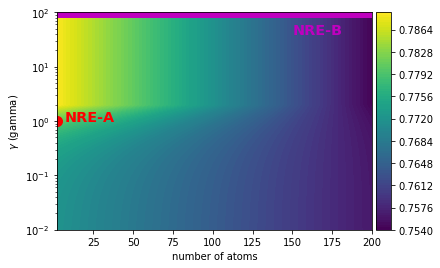

In [68]:
fig, ax = plt.subplots()
fontdict = {
    "fontsize": "x-large",
    "fontweight": "black",
}

# contour
CS = ax.contourf(
    xnew, 
    ynew, 
    znew,
    levels=100
)

# NRE-A
ax.scatter(
    x=2,
    y=1,
    s=100,
    c="r",
)

ax.text(x=2 + 5, y=1, s="NRE-A", fontdict=merge({"color": "r"}, fontdict))

# NRE-B
ax.hlines(
    y=10 ** ymax - 1.0,
    xmin=xmin,
    xmax=xmax,
    colors="m",
    linewidth=10.0
)

ax.text(x=150, y=10 ** ymax - 60, s="NRE-B", fontdict=merge({"color": "m"}, fontdict))

# labels
ax.set_ylabel(r"$\gamma$ (gamma)")
ax.set_yscale("log")
ax.set_xlabel("number of atoms")

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(CS, cax=cax)
plt.savefig("conceptual.png")

## polynomial

In [9]:
df_many = df.reset_index()[columns + ["C2ST_Z"]]
df_many = select_architechture_and_algorithm(df_many)
X = df_many[["num_atoms", "gamma"]].to_numpy()
y = df_many["C2ST_Z"].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [10]:
poly = PolynomialFeatures(degree=4)
poly.fit_transform(X_train)

ridge = GridSearchCV(
    Ridge(alpha=1.0),
    param_grid={"alpha": [1e-2, 1e-1, 1e0, 1e1, 1e2]}
)
ridge.fit(X, y)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]})

In [11]:
ridge.score(X_test, y_test)

-0.0016169046059835157

In [12]:
X, Y = np.meshgrid(xnew, ynew)
pts = np.stack([X, Y], axis=-1).reshape(-1, 2)
Z = ridge.predict(pts).reshape(N, N)

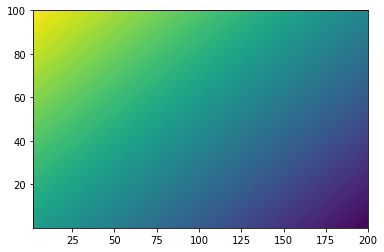

In [13]:
fig, ax = plt.subplots()
CS = ax.contourf(
    X, 
    Y, 
    Z,
    levels=100
)

In [14]:
raise NotImplementedError()

NotImplementedError: 

## validation lossreset_index

In [ ]:
root = Path("/home/ben/sci/cnre/infinite/")
experiment_folders = {
    "slcp": root / "outputs/2022-04-18/17-17-25",
    "two_moons": root / "outputs/2022-04-18/18-04-06",
    "gaussian_mixture": root / "outputs/2022-04-18/18-11-35",
    "gaussian_linear_uniform": root / "outputs/2022-04-18/18-24-56",
    # "slcp-big": root / "multirun/2022-04-19/10-20-49/2",
    # "two_moons-big": root / "multirun/2022-04-19/10-20-49/0",
    # "gaussian_mixture-big": root / "multirun/2022-04-19/10-20-49/1",
    # "gaussian_linear_uniform-big": root / "multirun/2022-04-19/10-20-49/3",
}
filename = "validation_loss.csv.bz2"

In [ ]:
fig, axes = plt.subplots(ncols=len(experiment_folders), sharey="row", figsize=(15,5))
for ax, (name, experiment_folder) in zip(axes.flatten(), experiment_folders.items()):
    validation_loss = get_tensor_from_csv(experiment_folder / filename)
    ax.semilogy(validation_loss)
    # ax.loglog(validation_loss)
    ax.set_title(name)

## metrics csv

`/home/ben/sci/cnre/infinite/multirun/2022-04-22/12-33-04` "big", CNRE `slcp` & `gaussian_mixture`, reuse=True  
`/home/ben/sci/cnre/infinite/multirun/2022-04-28/11-48-27` "big", CNRE `two_moons`, reuse=True  
`/home/ben/sci/cnre/infinite/multirun/2022-04-28/21-08-52` "big", NRE, `slcp` & `gaussian_mixture` & `two_moons`, reuse=True  


`/home/ben/sci/cnre/infinite/multirun/2022-04-29/*` two "big" runs, CNRE, `gaussian_mixture`, reuse=True  

`/home/ben/sci/cnre/infinite/multirun/2022-04-30/17-32-15/summarizemetrics.py` CNRE, `slcp`, `two_moons`, `gaussian_mixture`, reuse=False, 200 atoms  


This one is the first cheap prior runs:  
2022-05-02 both on das5 and nada

In [ ]:
files = [
    # "metrics-3layer-reuse-false.csv",
    # "metrics-2layer-reuse-false.csv", 
    "metrics-prior.csv", 
]
df = pd.concat([pd.read_csv(file, index_col=0) for file in files], ignore_index=True)
print(len(df))
print(df.columns)
print(df["algorithm"].unique())
df.head()

In [ ]:
# groupby drops NaNs fix this here.
df["gamma"] = df["gamma"].fillna(1.0)

df_wide = pd.wide_to_long(
    df, 
    ["C2ST_Z"], 
    i=["task", "algorithm", "num_atoms", "gamma", "num_blocks", "hidden_features", "seed"], 
    j="num_observation", 
    sep="-"
)

# groupby drops NaNs
grp = df_wide.groupby([
    "task",
    "algorithm",
    "num_atoms",
    "gamma",
    "num_blocks",
    "hidden_features",
])
grp.count()
# grp.aggregate({
#     "C2ST_Z": ["mean", "std"],
# })

In [ ]:
fg = sns.relplot(
    data=df_wide,
    x="num_atoms",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    col="task",
    row="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)
for ax in fg.axes.flatten():
    ax.set(xscale='log') 

In [ ]:
sns.relplot(
    data=df_wide,
    x="num_atoms",
    y="C2ST_Z",
    hue="gamma",
    style="algorithm",
    # col="task",
    row="num_blocks",
    kind="line",
    hue_norm=LogNorm(),
)